# Import Library

In [1]:
import numpy as np
import pandas as pd

# Import Data

In [2]:
loan_data_preprocessed_backup = pd.read_csv('C:\\Users\\scarl\\Desktop\\projects\\Credit Risk Modeling (Python)\\loan_data_2007_2014_preprocessed.csv')

C:\Users\scarl\AppData\Local\Temp\ipykernel_28684\3071859705.py:1: DtypeWarning: Columns (21,49) have mixed types. Specify dtype option on import or set low_memory=False.
  loan_data_preprocessed_backup = pd.read_csv('C:\\Users\\scarl\\Desktop\\projects\\Credit Risk Modeling (Python)\\loan_data_2007_2014_preprocessed.csv')


# Explore Data

In [3]:
loan_data_preprocessed = loan_data_preprocessed_backup.copy()

In [4]:
loan_data_preprocessed.columns.values

array(['Unnamed: 0.1', 'Unnamed: 0', 'id', 'member_id', 'loan_amnt',
       'funded_amnt', 'funded_amnt_inv', 'term', 'int_rate',
       'installment', 'grade', 'sub_grade', 'emp_title', 'emp_length',
       'home_ownership', 'annual_inc', 'verification_status', 'issue_d',
       'loan_status', 'pymnt_plan', 'url', 'desc', 'purpose', 'title',
       'zip_code', 'addr_state', 'dti', 'delinq_2yrs', 'earliest_cr_line',
       'inq_last_6mths', 'mths_since_last_delinq',
       'mths_since_last_record', 'open_acc', 'pub_rec', 'revol_bal',
       'revol_util', 'total_acc', 'initial_list_status', 'out_prncp',
       'out_prncp_inv', 'total_pymnt', 'total_pymnt_inv',
       'total_rec_prncp', 'total_rec_int', 'total_rec_late_fee',
       'recoveries', 'collection_recovery_fee', 'last_pymnt_d',
       'last_pymnt_amnt', 'next_pymnt_d', 'last_credit_pull_d',
       'collections_12_mths_ex_med', 'mths_since_last_major_derog',
       'policy_code', 'application_type', 'annual_inc_joint', 'dti_join

In [5]:
loan_data_preprocessed.head()

,Unnamed: 0.1,Unnamed: 0,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,...,addr_state:UT,addr_state:VA,addr_state:VT,addr_state:WA,addr_state:WI,addr_state:WV,addr_state:WY,initial_list_status:f,initial_list_status:w,good_bad
0,0,0,1077501,1296599,5000,5000,4975.0,36 months,10.65,162.87,...,0,0,0,0,0,0,0,1,0,1
1,1,1,1077430,1314167,2500,2500,2500.0,60 months,15.27,59.83,...,0,0,0,0,0,0,0,1,0,0
2,2,2,1077175,1313524,2400,2400,2400.0,36 months,15.96,84.33,...,0,0,0,0,0,0,0,1,0,1
3,3,3,1076863,1277178,10000,10000,10000.0,36 months,13.49,339.31,...,0,0,0,0,0,0,0,1,0,1
4,4,4,1075358,1311748,3000,3000,3000.0,60 months,12.69,67.79,...,0,0,0,0,0,0,0,1,0,1


It wouldn't be entirely accurate to include all accounts for LGD and EAD since after borrower have defaulted, they can repay part of the debt so that the lender can recover some of the debt they thought would be lost. Therefore, when building LGD and EAD models, it is a good practice to build models with data from borrowers that have enough time to repay part of the remaing debt.

In [6]:
loan_data_defaults = loan_data_preprocessed[loan_data_preprocessed['loan_status'].isin(['Charged Off','Does not meet the credit policy. Status:Charged Off'])]

In [7]:
loan_data_defaults.shape

(43236, 209)

In [8]:
pd.options.display.max_rows = None

In [9]:
loan_data_defaults.isnull().sum()

Unnamed: 0.1                                                           0
Unnamed: 0                                                             0
id                                                                     0
member_id                                                              0
loan_amnt                                                              0
funded_amnt                                                            0
funded_amnt_inv                                                        0
term                                                                   0
int_rate                                                               0
installment                                                            0
grade                                                                  0
sub_grade                                                              0
emp_title                                                           3287
emp_length                                         

# Tackle Missing Values of Independent Variables

Most conservative aprroach is to set missing values to 0, meaning the highest risk.

In [10]:
loan_data_defaults['mths_since_last_delinq'].fillna(0,inplace = True)

C:\Users\scarl\AppData\Local\Temp\ipykernel_28684\3255895574.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  loan_data_defaults['mths_since_last_delinq'].fillna(0,inplace = True)


In [11]:
loan_data_defaults['mths_since_last_record'].fillna(0,inplace = True)

C:\Users\scarl\AppData\Local\Temp\ipykernel_28684\4068106314.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  loan_data_defaults['mths_since_last_record'].fillna(0,inplace = True)


# Dependent Variables (Recovery Rate for LGD, Credit Conversion Factor for EAD)

LGD (Loss Given Default) is the proportion of the total exposure that a lender expects to lose in the event of a borrower's default, after accounting for any recoveries. = 1 - recovery rate

EAD (Exposure at Default) is the total value that a bank or lender is exposed to when a borrower defaults on a loan or credit facility. It is the maximum that a bank may lose when a borrower defaults.

We assume that for the defaulted borrowers 'funded_amnt' reflects the total amount that was lost the moment the borrower defaulted

In [12]:
loan_data_defaults['recovery_rate'] = loan_data_defaults['recoveries'] / loan_data_defaults['funded_amnt']

C:\Users\scarl\AppData\Local\Temp\ipykernel_28684\2670870593.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  loan_data_defaults['recovery_rate'] = loan_data_defaults['recoveries'] / loan_data_defaults['funded_amnt']


In [13]:
loan_data_defaults['recovery_rate'].describe()

count    43236.000000
mean         0.060820
std          0.089770
min          0.000000
25%          0.000000
50%          0.029466
75%          0.114044
max          1.220774
Name: recovery_rate, dtype: float64

In [14]:
# we observe that max recovery_rate is greater than 1, which is supposed to be in 0 and 1
loan_data_defaults['recovery_rate'] = np.where(loan_data_defaults['recovery_rate'] > 1, 1, loan_data_defaults['recovery_rate'])
loan_data_defaults['recovery_rate'] = np.where(loan_data_defaults['recovery_rate'] < 0, 0, loan_data_defaults['recovery_rate'])

C:\Users\scarl\AppData\Local\Temp\ipykernel_28684\1951486607.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  loan_data_defaults['recovery_rate'] = np.where(loan_data_defaults['recovery_rate'] > 1, 1, loan_data_defaults['recovery_rate'])
C:\Users\scarl\AppData\Local\Temp\ipykernel_28684\1951486607.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  loan_data_defaults['recovery_rate'] = np.where(loan_data_defaults['recovery_rate'] < 0, 0, loan_data_defaults['recovery_rate'])


In [15]:
loan_data_defaults['recovery_rate'].describe()

count    43236.000000
mean         0.060770
std          0.089202
min          0.000000
25%          0.000000
50%          0.029466
75%          0.114044
max          1.000000
Name: recovery_rate, dtype: float64

Credit Conversion Factor (CCF) means default at a % of the funded amount. EAD = total funded amount * CCF

In [16]:
# It is the ratio of the difference of the amount used at the moment of default to the total funded amount.
loan_data_defaults['CCF'] = (loan_data_defaults['funded_amnt'] - loan_data_defaults['total_rec_prncp']) / loan_data_defaults['funded_amnt']

C:\Users\scarl\AppData\Local\Temp\ipykernel_28684\98364314.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  loan_data_defaults['CCF'] = (loan_data_defaults['funded_amnt'] - loan_data_defaults['total_rec_prncp']) / loan_data_defaults['funded_amnt']


In [17]:
loan_data_defaults['CCF'].describe()

count    43236.000000
mean         0.735952
std          0.200742
min          0.000438
25%          0.632088
50%          0.789908
75%          0.888543
max          1.000000
Name: CCF, dtype: float64

In [18]:
loan_data_defaults.to_csv('C:\\Users\\scarl\\Desktop\\projects\\Credit Risk Modeling (Python)\\loan_data_defaults.csv')

# Explore Dependent Variables

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

(array([2.0651e+04, 3.7200e+02, 6.4200e+02, 1.1950e+03, 1.9300e+03,
        1.9430e+03, 6.4500e+02, 7.4900e+02, 8.9700e+02, 1.2360e+03,
        1.5530e+03, 1.7910e+03, 2.3140e+03, 2.4510e+03, 1.0410e+03,
        6.7200e+02, 7.0600e+02, 4.7300e+02, 1.9600e+02, 2.1000e+02,
        1.8600e+02, 1.5500e+02, 1.5900e+02, 1.1500e+02, 5.6000e+01,
        6.1000e+01, 4.2000e+01, 5.1000e+01, 4.6000e+01, 3.5000e+01,
        4.0000e+01, 3.3000e+01, 2.9000e+01, 2.5000e+01, 3.2000e+01,
        4.0000e+01, 2.7000e+01, 3.0000e+01, 1.6000e+01, 1.4000e+01,
        2.7000e+01, 2.0000e+01, 1.7000e+01, 1.0000e+01, 6.0000e+00,
        1.1000e+01, 5.0000e+00, 1.0000e+01, 1.1000e+01, 9.0000e+00,
        1.2000e+01, 1.1000e+01, 9.0000e+00, 8.0000e+00, 3.0000e+00,
        4.0000e+00, 3.0000e+00, 8.0000e+00, 2.0000e+00, 5.0000e+00,
        3.0000e+00, 5.0000e+00, 5.0000e+00, 2.0000e+00, 4.0000e+00,
        3.0000e+00, 6.0000e+00, 2.0000e+00, 3.0000e+00, 4.0000e+00,
        6.0000e+00, 4.0000e+00, 4.0000e+00, 2.00

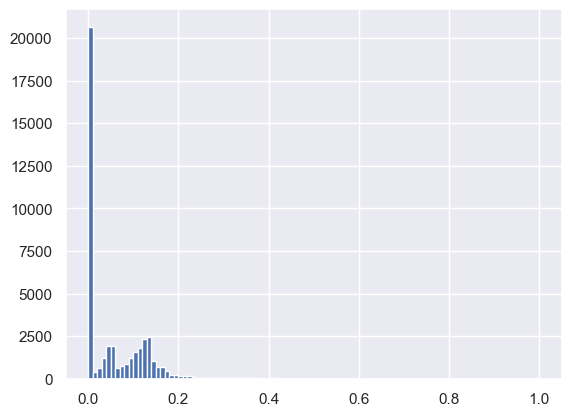

In [20]:
plt.hist(loan_data_defaults['recovery_rate'],bins = 100)

(array([2.1023e+04, 1.8370e+03, 3.8730e+03, 1.3940e+03, 2.1330e+03,
        3.3440e+03, 4.7650e+03, 1.7130e+03, 1.1790e+03, 4.0600e+02,
        3.4100e+02, 2.7400e+02, 1.1700e+02, 9.3000e+01, 8.1000e+01,
        7.3000e+01, 5.4000e+01, 7.2000e+01, 5.7000e+01, 3.0000e+01,
        4.7000e+01, 2.7000e+01, 1.7000e+01, 1.5000e+01, 2.0000e+01,
        2.3000e+01, 1.7000e+01, 7.0000e+00, 1.1000e+01, 7.0000e+00,
        8.0000e+00, 7.0000e+00, 7.0000e+00, 8.0000e+00, 7.0000e+00,
        1.0000e+01, 6.0000e+00, 1.1000e+01, 9.0000e+00, 9.0000e+00,
        6.0000e+00, 6.0000e+00, 6.0000e+00, 3.0000e+00, 9.0000e+00,
        9.0000e+00, 1.5000e+01, 8.0000e+00, 9.0000e+00, 3.3000e+01]),
 array([0.  , 0.02, 0.04, 0.06, 0.08, 0.1 , 0.12, 0.14, 0.16, 0.18, 0.2 ,
        0.22, 0.24, 0.26, 0.28, 0.3 , 0.32, 0.34, 0.36, 0.38, 0.4 , 0.42,
        0.44, 0.46, 0.48, 0.5 , 0.52, 0.54, 0.56, 0.58, 0.6 , 0.62, 0.64,
        0.66, 0.68, 0.7 , 0.72, 0.74, 0.76, 0.78, 0.8 , 0.82, 0.84, 0.86,
        0.88, 0.9 , 0.

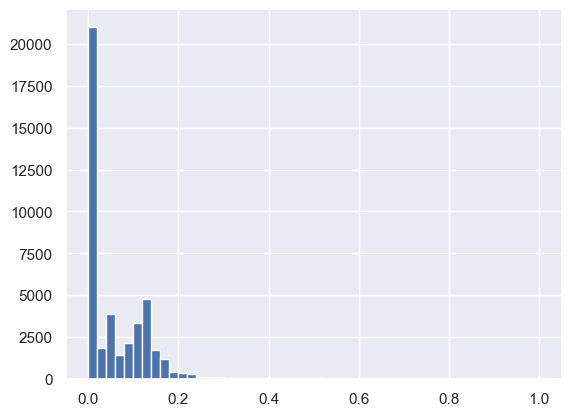

In [21]:
plt.hist(loan_data_defaults['recovery_rate'],bins = 50)

(array([   3.,   17.,   16.,   44.,   16.,   13.,   71.,   26.,    7.,
          63.,   67.,   17.,   60.,   90.,   23.,   55.,   82.,   42.,
          47.,  123.,   82.,   70.,  122.,   86.,   89.,  110.,  117.,
         111.,  122.,  120.,  135.,  141.,  154.,  146.,  160.,  175.,
         152.,  187.,  202.,  174.,  204.,  208.,  210.,  211.,  241.,
         264.,  281.,  224.,  308.,  267.,  287.,  296.,  340.,  274.,
         365.,  370.,  392.,  364.,  393.,  419.,  411.,  429.,  445.,
         497.,  481.,  478.,  569.,  568.,  599.,  618.,  727.,  691.,
         626.,  805.,  804.,  776.,  881.,  851.,  916.,  934.,  925.,
        1078.,  933., 1218., 1041., 1082., 1336., 1040., 1374., 1073.,
        1406., 1287.,  952., 1414.,  795., 1320.,  578.,  949.,  343.,
         531.]),
 array([4.3800000e-04, 1.0433620e-02, 2.0429240e-02, 3.0424860e-02,
        4.0420480e-02, 5.0416100e-02, 6.0411720e-02, 7.0407340e-02,
        8.0402960e-02, 9.0398580e-02, 1.0039420e-01, 1.1038982e-01

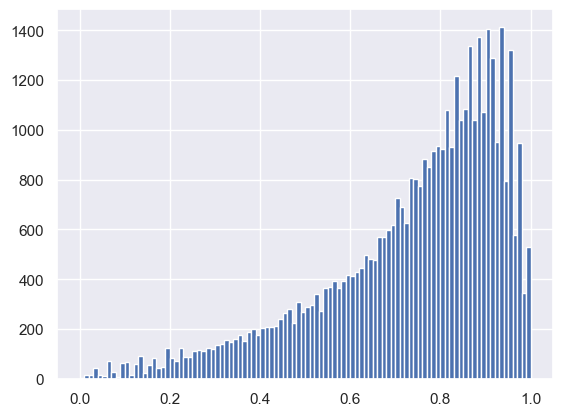

In [22]:
plt.hist(loan_data_defaults['CCF'],bins = 100)

Methodologically speaking, the density of the proportion is best described by Beta distribution. However, it is not supportive in python. Therefore, we use logistic regression instead

## LGD

Since about half of the recovery_rate are 0 and the rest of the rate are greater than 0, we can conduct a two stage approach. 

(1) is recovery rate equal to 0 or greater than 0? -- Logistic Regression

(2) if recovery rate is greater than 0, hw much exactly is it -- Linear Regression

In [23]:
loan_data_defaults['recovery_rate_0_1'] = np.where(loan_data_defaults['recovery_rate'] == 0, 0, 1)

C:\Users\scarl\AppData\Local\Temp\ipykernel_28684\3193898076.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  loan_data_defaults['recovery_rate_0_1'] = np.where(loan_data_defaults['recovery_rate'] == 0, 0, 1)


In [24]:
loan_data_defaults['recovery_rate_0_1'].head()

1     1
8     1
9     1
12    1
14    1
Name: recovery_rate_0_1, dtype: int32

## EAD

CCF are distributed bit more evenly. It seems that directly apply linear regression model to model CCF would produce satisfactory results. Therefore, we will apply a multiple linear regression model.

# LGD Model

## Stage 1 - Logistic REgression

### Splitting Data

In [25]:
from sklearn.model_selection import train_test_split

In [26]:
lgd_inputs_stage_1_train, lgd_inputs_stage_1_test, lgd_targets_stage_1_train, lgd_targets_stage_1_test = train_test_split(loan_data_defaults.drop(['good_bad','recovery_rate','recovery_rate_0_1','CCF'], axis = 1),loan_data_defaults['recovery_rate_0_1'], test_size = 0.2, random_state = 42)

In [27]:
lgd_inputs_stage_1_train.columns

Index(['Unnamed: 0.1', 'Unnamed: 0', 'id', 'member_id', 'loan_amnt',
       'funded_amnt', 'funded_amnt_inv', 'term', 'int_rate', 'installment',
       ...
       'addr_state:TX', 'addr_state:UT', 'addr_state:VA', 'addr_state:VT',
       'addr_state:WA', 'addr_state:WI', 'addr_state:WV', 'addr_state:WY',
       'initial_list_status:f', 'initial_list_status:w'],
      dtype='object', length=208)

### Preparing the Inputs

In [28]:
# List of all independent variables for the models.
features_all = ['grade:A',
'grade:B',
'grade:C',
'grade:D',
'grade:E',
'grade:F',
'grade:G',
'home_ownership:MORTGAGE',
'home_ownership:NONE',
'home_ownership:OTHER',
'home_ownership:OWN',
'home_ownership:RENT',
'verification_status:Not Verified',
'verification_status:Source Verified',
'verification_status:Verified',
'purpose:car',
'purpose:credit_card',
'purpose:debt_consolidation',
'purpose:educational',
'purpose:home_improvement',
'purpose:house',
'purpose:major_purchase',
'purpose:medical',
'purpose:moving',
'purpose:other',
'purpose:renewable_energy',
'purpose:small_business',
'purpose:vacation',
'purpose:wedding',
'initial_list_status:f',
'initial_list_status:w',
'term_int',
'emp_length_int',
'mths_since_issue_d',
'mths_since_earliest_cr_line',
'funded_amnt',
'int_rate',
'installment',
'annual_inc',
'dti',
'delinq_2yrs',
'inq_last_6mths',
'mths_since_last_delinq',
'mths_since_last_record',
'open_acc',
'pub_rec',
'total_acc',
'acc_now_delinq',
'total_rev_hi_lim']

In [29]:
# List of the dummy variable reference categories. (only for originally discrete features) 
features_reference_cat = ['grade:G',
'home_ownership:RENT',
'verification_status:Verified',
'purpose:credit_card',
'initial_list_status:f']

In [30]:
lgd_inputs_stage_1_train = lgd_inputs_stage_1_train[features_all]

In [31]:
lgd_inputs_stage_1_train = lgd_inputs_stage_1_train.drop(features_reference_cat, axis = 1)

### Estimating the Model

In [32]:
from sklearn import linear_model
import scipy.stats as stat

class LogisticRegression_with_p_values:
    
    def __init__(self,*args,**kwargs):#,**kwargs):
        self.model = linear_model.LogisticRegression(*args,**kwargs)#,**args)

    def fit(self,X,y):
        self.model.fit(X,y)
        
        #### Get p-values for the fitted model ####
        denom = (2.0 * (1.0 + np.cosh(self.model.decision_function(X))))
        denom = np.tile(denom,(X.shape[1],1)).T
        F_ij = np.dot((X / denom).T,X) ## Fisher Information Matrix
        Cramer_Rao = np.linalg.inv(F_ij) ## Inverse Information Matrix
        sigma_estimates = np.sqrt(np.diagonal(Cramer_Rao))
        z_scores = self.model.coef_[0] / sigma_estimates # z-score for eaach model coefficient
        p_values = [stat.norm.sf(abs(x)) * 2 for x in z_scores] ### two tailed test for p-values
        
        self.coef_ = self.model.coef_
        self.intercept_ = self.model.intercept_
        #self.z_scores = z_scores
        self.p_values = p_values
        #self.sigma_estimates = sigma_estimates
        #self.F_ij = F_ij

In [33]:
reg_lgd_st_1 = LogisticRegression_with_p_values()
reg_lgd_st_1.fit(lgd_inputs_stage_1_train, lgd_targets_stage_1_train)

C:\Users\scarl\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [34]:
feature_name = lgd_inputs_stage_1_train.columns.values

In [35]:
summary_table = pd.DataFrame(columns = ['Feature name'], data = feature_name)
summary_table['Coefficients'] = np.transpose(reg_lgd_st_1.coef_)
summary_table.index = summary_table.index + 1
summary_table.loc[0] = ['Intercept', reg_lgd_st_1.intercept_[0]]
# Assigns values of the row with index 0 of the dataframe.
summary_table = summary_table.sort_index()
p_values = reg_lgd_st_1.p_values
p_values = np.append(np.nan,np.array(p_values))
summary_table['p_values'] = p_values
summary_table

,Feature name,Coefficients,p_values
0,Intercept,-8.104496e-05,NaN
1,grade:A,-9.873194e-06,9.999064e-01
2,grade:B,-6.569182e-05,9.992309e-01
3,grade:C,-1.318713e-04,9.984031e-01
4,grade:D,2.240625e-05,9.997396e-01
5,grade:E,1.579774e-05,9.998336e-01
6,grade:F,7.584069e-05,9.993050e-01
7,home_ownership:MORTGAGE,-3.578021e-05,9.988741e-01
8,home_ownership:NONE,9.226628e-07,9.999991e-01
9,home_ownership:OTHER,6.699893e-07,9.999986e-01


For continuous variables, the coefficient reflects the change in the log-odds of recovery_rate > 0 (versus recovery_rate = 0) for a one-unit increase in the respective variable. For instance, for the feature funded_amnt, every unit increase in the funded amount is associated with a 0.0000272 increase in the log-odds of recovery_rate > 0 compared to recovery_rate = 0.

For categorical variables (represented by dummy variables), the coefficient reflects the change in the log-odds relative to the reference category. For example, for grade:D, the coefficient of 0.0000224 means that borrowers with grade D have a 0.0000224 higher log-odds of recovery_rate > 0 compared to the reference category, which is grade:G.

### Testing the Model

In [36]:
lgd_inputs_stage_1_test = lgd_inputs_stage_1_test[features_all]

In [37]:
lgd_inputs_stage_1_test = lgd_inputs_stage_1_test.drop(features_reference_cat, axis = 1)

In [38]:
y_hat_test_lgd_stage_1 = reg_lgd_st_1.model.predict(lgd_inputs_stage_1_test)

In [39]:
y_hat_test_lgd_stage_1

array([1, 1, 0, ..., 0, 1, 1])

In [40]:
# We just get the raw predictions about the recovery rate. But it would be better to get the estimated probabilities of the recovery rate value.
y_hat_test_proba_lgd_stage_1 = reg_lgd_st_1.model.predict_proba(lgd_inputs_stage_1_test)

In [41]:
y_hat_test_proba_lgd_stage_1

array([[0.39300638, 0.60699362],
       [0.38838315, 0.61161685],
       [0.54294807, 0.45705193],
       ...,
       [0.50001978, 0.49998022],
       [0.40790493, 0.59209507],
       [0.45737951, 0.54262049]])

In [42]:
y_hat_test_proba_lgd_stage_1 = y_hat_test_proba_lgd_stage_1[:][:,1]
y_hat_test_proba_lgd_stage_1

array([0.60699362, 0.61161685, 0.45705193, ..., 0.49998022, 0.59209507,
       0.54262049])

In [43]:
lgd_targets_stage_1_test_temp = lgd_targets_stage_1_test

In [44]:
lgd_targets_stage_1_test_temp.reset_index(drop = True, inplace = True)

In [45]:
df_actual_predicted_probs = pd.concat([lgd_targets_stage_1_test_temp,pd.DataFrame(y_hat_test_proba_lgd_stage_1)],axis = 1)

In [46]:
df_actual_predicted_probs.columns = ['lgd_targets_stage_1_test','y_hat_test_proba_lgd_stage_1']

In [47]:
df_actual_predicted_probs.index = lgd_inputs_stage_1_test.index

In [48]:
df_actual_predicted_probs.head()

,lgd_targets_stage_1_test,y_hat_test_proba_lgd_stage_1
178928,1,0.606994
69814,1,0.611617
101396,0,0.457052
463268,1,0.556264
253729,0,0.416456


### Estimating the Accuracy of the Model

In [49]:
tr = 0.5
df_actual_predicted_probs['y_hat_test_lgd_stage_1'] = np.where(df_actual_predicted_probs['y_hat_test_proba_lgd_stage_1'] > tr, 1, 0)

In [50]:
pd.crosstab(df_actual_predicted_probs['lgd_targets_stage_1_test'], df_actual_predicted_probs['y_hat_test_lgd_stage_1'], rownames = ['Actual'], colnames = ['Predicted'])

Predicted,0,1
Actual,,
0,983,2779
1,684,4202


In [51]:
pd.crosstab(df_actual_predicted_probs['lgd_targets_stage_1_test'], df_actual_predicted_probs['y_hat_test_lgd_stage_1'], rownames = ['Actual'], colnames = ['Predicted']) / df_actual_predicted_probs.shape[0]

Predicted,0,1
Actual,,
0,0.113668,0.321346
1,0.079093,0.485893


In [52]:
(pd.crosstab(df_actual_predicted_probs['lgd_targets_stage_1_test'], df_actual_predicted_probs['y_hat_test_lgd_stage_1'], rownames = ['Actual'], colnames = ['Predicted']) / df_actual_predicted_probs.shape[0]).iloc[0, 0] + (pd.crosstab(df_actual_predicted_probs['lgd_targets_stage_1_test'], df_actual_predicted_probs['y_hat_test_lgd_stage_1'], rownames = ['Actual'], colnames = ['Predicted']) / df_actual_predicted_probs.shape[0]).iloc[1, 1]

0.5995605920444034

However, accuracy at a given cut-off is not as informative as the ROC curve

In [53]:
from sklearn.metrics import roc_curve, roc_auc_score

In [54]:
fpr, tpr, thresholds = roc_curve(df_actual_predicted_probs['lgd_targets_stage_1_test'], df_actual_predicted_probs['y_hat_test_proba_lgd_stage_1'])

Text(0.5, 1.0, 'ROC curve')

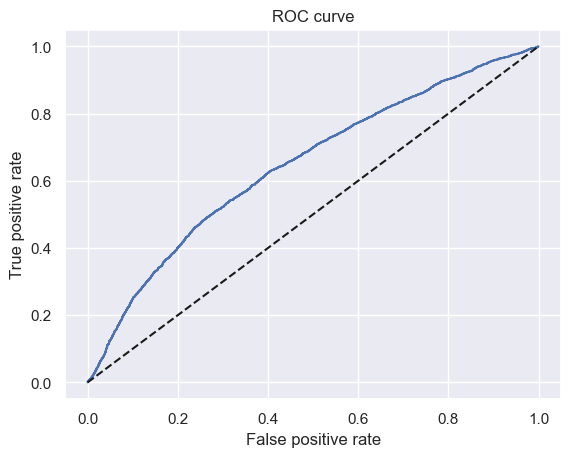

In [55]:
plt.plot(fpr, tpr)
plt.plot(fpr, fpr, linestyle = '--', color = 'k')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')

In [56]:
AUROC = roc_auc_score(df_actual_predicted_probs['lgd_targets_stage_1_test'], df_actual_predicted_probs['y_hat_test_proba_lgd_stage_1'])
AUROC

0.6466881909122899

It is the first stage of LGD model. Since during the 2nd stage when we apply the linear regression model, some of the values are classified as > 1 maybe estimated to be = 0, thus correcting the current misclassification. So it is more important to have a large proportion of correctly classified values that are greater than 0, than to have correctly classified as 0.

### Saving the Model

In [57]:
import pickle

In [58]:
# pickle.dump(model, open(filename, 'wb')), which converts a python model into a character string and saves in a file
# 'dump' means save
# 'model' is the object to be dumped
# 'wb' means write bytes. COnversely, when we unpickle, we use rd, read pickle.
pickle.dump(reg_lgd_st_1,open('lgd_model_stage_1.sav', 'wb'))

## Stage 2 - Linear Regression

### Splitting Data and Estimating Model

In [69]:
lgd_stage_2_data = loan_data_defaults[loan_data_defaults['recovery_rate_0_1'] == 1]

In [70]:
lgd_inputs_stage_2_train, lgd_inputs_stage_2_test, lgd_targets_stage_2_train, lgd_targets_stage_2_test = train_test_split(lgd_stage_2_data.drop(['good_bad', 'recovery_rate','recovery_rate_0_1', 'CCF'], axis = 1), lgd_stage_2_data['recovery_rate'], test_size = 0.2, random_state = 42)

In [71]:
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score

In [72]:
import numpy as np
import scipy.stats as stat
from sklearn import linear_model

class LinearRegression(linear_model.LinearRegression):
    """
    LinearRegression class after sklearn's, but calculates t-statistics
    and p-values for model coefficients (betas).
    Additional attributes available after .fit()
    are t and p which are of the shape (n_features,)
    This class sets the intercept to 0 by default, since usually we include it
    in X.
    """
    
    def __init__(self, fit_intercept=True, copy_X=True, n_jobs=1, positive=False):
        super(LinearRegression, self).__init__(fit_intercept=fit_intercept, copy_X=copy_X, n_jobs=n_jobs, positive=positive)

    def fit(self, X, y, n_jobs=1):
        super(LinearRegression, self).fit(X, y, n_jobs)
        
        # Calculate SSE (sum of squared errors)
        sse = np.sum((self.predict(X) - y) ** 2, axis=0) / float(X.shape[0] - X.shape[1])
        # Calculate SE (standard error)
        se = np.array([np.sqrt(np.diagonal(sse * np.linalg.inv(np.dot(X.T, X))))])

        # Compute the t-statistic for each feature
        self.t = self.coef_ / se
        # Find the p-value for each feature
        self.p = np.squeeze(2 * (1 - stat.t.cdf(np.abs(self.t), y.shape[0] - X.shape[1])))
        return self

In [73]:
lgd_inputs_stage_2_train = lgd_inputs_stage_2_train[features_all]

In [74]:
lgd_inputs_stage_2_train = lgd_inputs_stage_2_train.drop(features_reference_cat, axis = 1)

In [75]:
lgd_targets_stage_2_train.head()

231132    0.174157
224522    0.037034
188577    0.259313
188396    0.055503
336956    0.139995
Name: recovery_rate, dtype: float64

In [76]:
reg_lgd_st_2 = LinearRegression()
reg_lgd_st_2.fit(lgd_inputs_stage_2_train, lgd_targets_stage_2_train)

LinearRegression()

In [77]:
feature_name = lgd_inputs_stage_2_train.columns.values

In [78]:
summary_table = pd.DataFrame(columns = ['Feature name'], data = feature_name)
summary_table['Coefficients'] = np.transpose(reg_lgd_st_2.coef_)
summary_table.index = summary_table.index + 1
summary_table.loc[0] = ['Intercept', reg_lgd_st_2.intercept_]
summary_table = summary_table.sort_index()
p_values = reg_lgd_st_2.p
p_values = np.append(np.nan,np.array(p_values))
summary_table['p_values'] = p_values.round(3)
summary_table

,Feature name,Coefficients,p_values
0,Intercept,2.406858e-01,NaN
1,grade:A,-6.826892e-02,0.000
2,grade:B,-5.083556e-02,0.000
3,grade:C,-3.748066e-02,0.000
4,grade:D,-2.717310e-02,0.000
5,grade:E,-1.315941e-02,0.002
6,grade:F,-5.260168e-03,0.275
7,home_ownership:MORTGAGE,2.832212e-03,0.061
8,home_ownership:NONE,1.459035e-01,0.000
9,home_ownership:OTHER,-9.475922e-03,0.644


The coefficient in a linear regression model represents the expected change in the dependent variable (e.g., recovery rate) for a one-unit change in the respective independent variable, holding all other variables constant.

For categorical variables such as purpose, the coefficient reflects the difference in the recovery rate relative to the baseline category. For example, if the loan purpose is for educational purposes (purpose:educational), the recovery rate is expected to be 7.625% higher than for the baseline category (e.g., purpose:other).

For continuous variables such as annual income, the coefficient represents the effect of a one-unit increase in the independent variable on the dependent variable. In the case of annual_inc, each additional dollar of income is expected to increase the recovery rate by 0.00000639%. Though this change is small per dollar, larger income changes could result in more noticeable effects.

### Evaluation of the Model

In [79]:
lgd_inputs_stage_2_test = lgd_inputs_stage_2_test[features_all]

In [80]:
lgd_inputs_stage_2_test = lgd_inputs_stage_2_test.drop(features_reference_cat, axis = 1)

In [81]:
lgd_inputs_stage_2_test.columns.values

array(['grade:A', 'grade:B', 'grade:C', 'grade:D', 'grade:E', 'grade:F',
       'home_ownership:MORTGAGE', 'home_ownership:NONE',
       'home_ownership:OTHER', 'home_ownership:OWN',
       'verification_status:Not Verified',
       'verification_status:Source Verified', 'purpose:car',
       'purpose:debt_consolidation', 'purpose:educational',
       'purpose:home_improvement', 'purpose:house',
       'purpose:major_purchase', 'purpose:medical', 'purpose:moving',
       'purpose:other', 'purpose:renewable_energy',
       'purpose:small_business', 'purpose:vacation', 'purpose:wedding',
       'initial_list_status:w', 'term_int', 'emp_length_int',
       'mths_since_issue_d', 'mths_since_earliest_cr_line', 'funded_amnt',
       'int_rate', 'installment', 'annual_inc', 'dti', 'delinq_2yrs',
       'inq_last_6mths', 'mths_since_last_delinq',
       'mths_since_last_record', 'open_acc', 'pub_rec', 'total_acc',
       'acc_now_delinq', 'total_rev_hi_lim'], dtype=object)

In [82]:
y_hat_test_lgd_stage_2 = reg_lgd_st_2.predict(lgd_inputs_stage_2_test)

In [83]:
lgd_targets_stage_2_test_temp = lgd_targets_stage_2_test

In [84]:
lgd_targets_stage_2_test_temp = lgd_targets_stage_2_test_temp.reset_index(drop = True)

In [85]:
pd.concat([lgd_targets_stage_2_test_temp, pd.DataFrame(y_hat_test_lgd_stage_2, columns=['predicted_recovery_rate'])], axis = 1).corr()

,recovery_rate,predicted_recovery_rate
recovery_rate,1.000000,0.307996
predicted_recovery_rate,0.307996,1.000000


In [86]:
# lgd_targets_stage_2_test_temp.head()

The correlation between actual and predicted values are about 0.308. It is weak to moderate positive correlation in general, but satisfactory for LGD model. If the correlation was too high, we would have actually questioned our methodology.

C:\Users\scarl\AppData\Local\Temp\ipykernel_28684\483740359.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(lgd_targets_stage_2_test - y_hat_test_lgd_stage_2)


<Axes: xlabel='recovery_rate', ylabel='Density'>

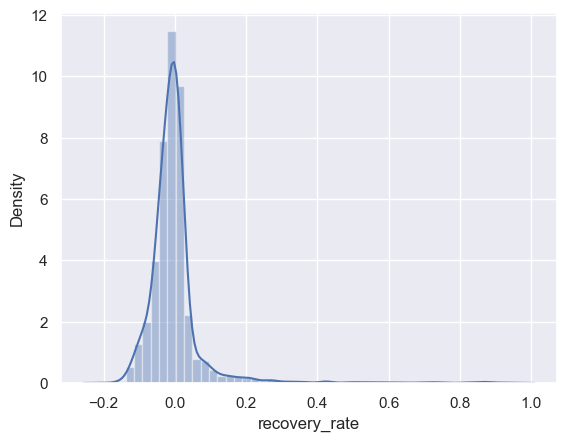

In [87]:
sns.distplot(lgd_targets_stage_2_test - y_hat_test_lgd_stage_2)

The residual distribution resembles a normal distribution, meaning that most of the residuals are symmetrically distributed around 0. So it seems to be a good model methodologically.

In [88]:
pickle.dump(reg_lgd_st_2, open('lgd_model_stage_2','wb'))

## Combining Stage 1 and Stage 2

In [89]:
y_hat_test_lgd_stage_2_all = reg_lgd_st_2.predict(lgd_inputs_stage_1_test)

In [90]:
# This is the recovery rates estimated by the linear regression, no matter if they were predicted to be 0 or 1 by the first stage
y_hat_test_lgd_stage_2_all

array([0.1193906 , 0.09605635, 0.13367631, ..., 0.12078611, 0.11587422,
       0.15667447])

We can reach the combined estimation by simply multiplying the predicted values from the two models

In [91]:
y_hat_test_lgd = y_hat_test_lgd_stage_1 * y_hat_test_lgd_stage_2_all

In [92]:
pd.DataFrame(y_hat_test_lgd).describe()

,0
count,8648.000000
mean,0.087315
std,0.049849
min,-0.007634
25%,0.065273
50%,0.101206
75%,0.123573
max,0.236973


We see that min is -0.007634, meaning that linear regression model is not constrained to produce only between 0 and 1

In [93]:
y_hat_test_lgd = np.where(y_hat_test_lgd < 0, 0, y_hat_test_lgd)
y_hat_test_lgd = np.where(y_hat_test_lgd > 1, 1, y_hat_test_lgd)
pd.DataFrame(y_hat_test_lgd).describe()

,0
count,8648.000000
mean,0.087317
std,0.049846
min,0.000000
25%,0.065273
50%,0.101206
75%,0.123573
max,0.236973


# EAD Model

## Estimation and Interpretation

The dependent variable for EAD model is the credit conversion factor (CCF): the proportion from the original amount of the loan that is still outstanding at the moment when the borrower defaulted.

In [94]:
ead_inputs_train, ead_inputs_test, ead_targets_train, ead_targets_test = train_test_split(loan_data_defaults.drop(['good_bad', 'recovery_rate','recovery_rate_0_1', 'CCF'], axis = 1), loan_data_defaults['CCF'], test_size = 0.2, random_state = 42)

When we investigated the distribution of CCF, we concluded that we can rely only on a simple linear regression model.

In [95]:
ead_inputs_train.columns.values

array(['Unnamed: 0.1', 'Unnamed: 0', 'id', 'member_id', 'loan_amnt',
       'funded_amnt', 'funded_amnt_inv', 'term', 'int_rate',
       'installment', 'grade', 'sub_grade', 'emp_title', 'emp_length',
       'home_ownership', 'annual_inc', 'verification_status', 'issue_d',
       'loan_status', 'pymnt_plan', 'url', 'desc', 'purpose', 'title',
       'zip_code', 'addr_state', 'dti', 'delinq_2yrs', 'earliest_cr_line',
       'inq_last_6mths', 'mths_since_last_delinq',
       'mths_since_last_record', 'open_acc', 'pub_rec', 'revol_bal',
       'revol_util', 'total_acc', 'initial_list_status', 'out_prncp',
       'out_prncp_inv', 'total_pymnt', 'total_pymnt_inv',
       'total_rec_prncp', 'total_rec_int', 'total_rec_late_fee',
       'recoveries', 'collection_recovery_fee', 'last_pymnt_d',
       'last_pymnt_amnt', 'next_pymnt_d', 'last_credit_pull_d',
       'collections_12_mths_ex_med', 'mths_since_last_major_derog',
       'policy_code', 'application_type', 'annual_inc_joint', 'dti_join

In [96]:
# Here we keep only the variables we need for the model.
ead_inputs_train = ead_inputs_train[features_all]

In [97]:
# Here we remove the dummy variable reference categories.
ead_inputs_train = ead_inputs_train.drop(features_reference_cat, axis = 1)

The reason that we always need to drop the reference category is to prevent multicollinearity. Multicollinearity makes it difficult for regression models to accurately estimate coefficients, leading to unstable or hard-to-interpret coefficients. This happens because the model struggles to differentiate the individual effects of correlated variables, resulting in unreliable significance tests, reduced explanatory power, and, in severe cases, an inability to perform regression at all due to an irreversible matrix. 

In [98]:
reg_ead = LinearRegression()
reg_ead.fit(ead_inputs_train,ead_targets_train)

LinearRegression()

In [99]:
feature_name = ead_inputs_train.columns.values

In [100]:
summary_table = pd.DataFrame(columns = ['Feature name'], data = feature_name)
summary_table['Coefficients'] = np.transpose(reg_ead.coef_)
summary_table.index = summary_table.index + 1
summary_table.loc[0] = ['Intercept', reg_ead.intercept_]
summary_table = summary_table.sort_index()
p_values = reg_ead.p
p_values = np.append(np.nan,np.array(p_values))
summary_table['p_values'] = p_values
summary_table

,Feature name,Coefficients,p_values
0,Intercept,1.109746e+00,NaN
1,grade:A,-3.030033e-01,0.000000e+00
2,grade:B,-2.364277e-01,0.000000e+00
3,grade:C,-1.720232e-01,0.000000e+00
4,grade:D,-1.198470e-01,0.000000e+00
5,grade:E,-6.768713e-02,0.000000e+00
6,grade:F,-2.045907e-02,4.428795e-03
7,home_ownership:MORTGAGE,-6.343341e-03,2.632464e-03
8,home_ownership:NONE,-5.539064e-03,9.318931e-01
9,home_ownership:OTHER,-2.426052e-03,9.335820e-01


Positive coefficient indicates an increase in the CCF, vise versa. Higher CCF indicates the amount of exposure at the moment the borrower defaults would be higher.

For categorical variable like grade A, the coefficient -0.303. It means if the borrower has an external credit grade A, their CCF is expected to be 30.3% lower than who has an external creadit grade G(reference category).

For categorical variable like purpose:educational, the coefficient is 0.09644. It means if the borrowers' purpose of loan is educational, their CCF are expected to be 9.644% more than those whose purpose is for credit-card(reference category).

For continuous variable like int_rate, its coefficient is -0.01173. It means with each percentage increase in interest rate, the expected CCF would be 1.173% lower.

## Model Evaluation

In [101]:
ead_inputs_test = ead_inputs_test[features_all]

In [102]:
ead_inputs_test = ead_inputs_test.drop(features_reference_cat, axis = 1)

In [103]:
y_hat_test_ead = reg_ead.predict(ead_inputs_test)

In [104]:
# we want to concat y_hat_test_ead (an array) and ead_targets_test (a data frame). 
# concat is based on index, we solve the issue by storing the targets dataframe into a temporary dataframe.
ead_targets_test_temp = ead_targets_test

In [105]:
ead_targets_test_temp = ead_targets_test_temp.reset_index(drop = True)

In [106]:
pd.concat([ead_targets_test_temp,pd.DataFrame(y_hat_test_ead)], axis = 1).corr()

,CCF,0
CCF,1.000000,0.530654
0,0.530654,1.000000


The correlation between actual and predicted value is about 0.53. This is moderately to strong positive correlation, which is good for the linear model. FUrthermore, to make sure the model is ok, we can look at distribution of residuals.

C:\Users\scarl\anaconda3\Lib\site-packages\seaborn\axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


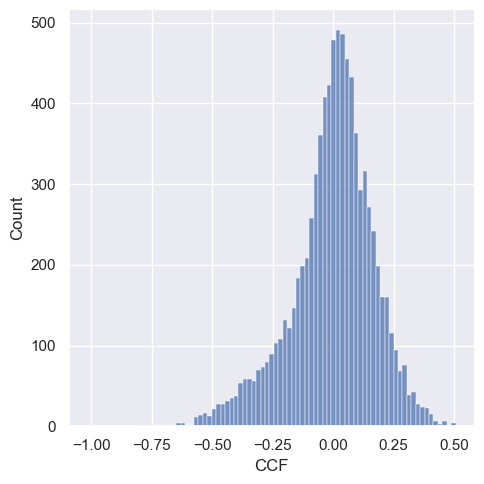

In [107]:
sns.displot(ead_targets_test - y_hat_test_ead)

The residuals resemble a normal distribution and most of the residuals are symmetrically distributed around 0. SO the model predictive power is relatively good, and it seems to be a methodologically good model.

In [108]:
pd.DataFrame(y_hat_test_ead).describe()

,0
count,8648.000000
mean,0.736013
std,0.105194
min,0.384774
25%,0.661553
50%,0.731750
75%,0.810625
max,1.161088


The max predicted CCF is greater than 1. We see predicted values greater than 1 because the linear regression model is not constrained to produce predicted values in the interval (0,1), even though that it was estimated by independent features that are in 0 and 1

In [109]:
y_hat_test_ead = np.where(y_hat_test_ead > 1, 1, y_hat_test_ead)
y_hat_test_ead = np.where(y_hat_test_ead < 0, 0, y_hat_test_ead)

In [110]:
pd.DataFrame(y_hat_test_ead).describe()

,0
count,8648.000000
mean,0.735992
std,0.105127
min,0.384774
25%,0.661553
50%,0.731750
75%,0.810625
max,1.000000


# Expected Loss

## Calculate LGD

Expected loss is the sum of the expected lossess of all accounts

In [111]:
loan_data_preprocessed.head()

,Unnamed: 0.1,Unnamed: 0,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,...,addr_state:UT,addr_state:VA,addr_state:VT,addr_state:WA,addr_state:WI,addr_state:WV,addr_state:WY,initial_list_status:f,initial_list_status:w,good_bad
0,0,0,1077501,1296599,5000,5000,4975.0,36 months,10.65,162.87,...,0,0,0,0,0,0,0,1,0,1
1,1,1,1077430,1314167,2500,2500,2500.0,60 months,15.27,59.83,...,0,0,0,0,0,0,0,1,0,0
2,2,2,1077175,1313524,2400,2400,2400.0,36 months,15.96,84.33,...,0,0,0,0,0,0,0,1,0,1
3,3,3,1076863,1277178,10000,10000,10000.0,36 months,13.49,339.31,...,0,0,0,0,0,0,0,1,0,1
4,4,4,1075358,1311748,3000,3000,3000.0,60 months,12.69,67.79,...,0,0,0,0,0,0,0,1,0,1


In [113]:
loan_data_preprocessed['mths_since_last_delinq'].fillna(0, inplace = True)
loan_data_preprocessed['mths_since_last_record'].fillna(0, inplace = True)

Now the data we used for the LGD and EAD is the same, but it differs from that for the PD model.

In [114]:
loan_data_preprocessed_lgd_ead = loan_data_preprocessed[features_all]

In [115]:
loan_data_preprocessed_lgd_ead = loan_data_preprocessed_lgd_ead.drop(features_reference_cat, axis = 1)

In [117]:
loan_data_preprocessed['recovery_rate_st_1'] = reg_lgd_st_1.model.predict(loan_data_preprocessed_lgd_ead)

In [119]:
loan_data_preprocessed['recovery_rate_st_2'] = reg_lgd_st_2.predict(loan_data_preprocessed_lgd_ead)

In [120]:
loan_data_preprocessed['recovery_rate'] = loan_data_preprocessed['recovery_rate_st_1'] * loan_data_preprocessed['recovery_rate_st_2']

In [121]:
loan_data_preprocessed['recovery_rate'] = np.where(loan_data_preprocessed['recovery_rate'] < 0, 0, loan_data_preprocessed['recovery_rate'])
loan_data_preprocessed['recovery_rate'] = np.where(loan_data_preprocessed['recovery_rate'] > 1, 1, loan_data_preprocessed['recovery_rate'])

In [122]:
loan_data_preprocessed['LGD'] = 1 - loan_data_preprocessed['recovery_rate']

In [123]:
loan_data_preprocessed['LGD'].describe()

count    466285.000000
mean          0.920122
std           0.057511
min           0.659786
25%           0.873189
50%           0.899132
75%           1.000000
max           1.000000
Name: LGD, dtype: float64

## Calculate EAD

In [126]:
loan_data_preprocessed['CCF'] = reg_ead.predict(loan_data_preprocessed_lgd_ead)

In [127]:
loan_data_preprocessed['CCF'] = np.where(loan_data_preprocessed['CCF'] < 0, 0, loan_data_preprocessed['CCF'])
loan_data_preprocessed['CCF'] = np.where(loan_data_preprocessed['CCF'] > 1, 1, loan_data_preprocessed['CCF'])

In [128]:
loan_data_preprocessed['EAD'] = loan_data_preprocessed['CCF'] * loan_data_preprocessed_lgd_ead['funded_amnt']

In [129]:
loan_data_preprocessed['EAD'].describe()

count    466285.000000
mean      10814.846760
std        6935.184562
min         190.347372
25%        5495.101413
50%        9208.479591
75%       14692.844549
max       35000.000000
Name: EAD, dtype: float64

## PD Model

For PD model, we need an entirely different set of input variables, which are the dummy variables we created specifically for the PD model

In [131]:
loan_data_preprocessed.head()

,Unnamed: 0.1,Unnamed: 0,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,...,addr_state:WY,initial_list_status:f,initial_list_status:w,good_bad,recovery_rate_st_1,recovery_rate_st_2,recovery_rate,LGD,CCF,EAD
0,0,0,1077501,1296599,5000,5000,4975.0,36 months,10.65,162.87,...,0,1,0,1,1,0.086271,0.086271,0.913729,0.589922,2949.608449
1,1,1,1077430,1314167,2500,2500,2500.0,60 months,15.27,59.83,...,0,1,0,0,1,0.084518,0.084518,0.915482,0.777773,1944.433378
2,2,2,1077175,1313524,2400,2400,2400.0,36 months,15.96,84.33,...,0,1,0,1,1,0.080516,0.080516,0.919484,0.658306,1579.934302
3,3,3,1076863,1277178,10000,10000,10000.0,36 months,13.49,339.31,...,0,1,0,1,1,0.095076,0.095076,0.904924,0.660656,6606.559612
4,4,4,1075358,1311748,3000,3000,3000.0,60 months,12.69,67.79,...,0,1,0,1,1,0.088547,0.088547,0.911453,0.708211,2124.631667


In [133]:
# We import data to apply the PD model.
loan_data_inputs_train = pd.read_csv('loan_data_inputs_train.csv')

In [134]:
loan_data_inputs_test = pd.read_csv('loan_data_inputs_test.csv')

In [135]:
loan_data_inputs_pd = pd.concat([loan_data_inputs_train, loan_data_inputs_test], axis = 0)

In [136]:
loan_data_inputs_pd.shape

(466285, 325)

In [137]:
loan_data_preprocessed.shape

(466285, 215)

In [138]:
loan_data_inputs_pd.head()

,Unnamed: 0.1,Unnamed: 0,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,...,dti:21.7-22.4,dti:22.4-35,dti:>35,mths_since_last_record:Missing,mths_since_last_record:0-2,mths_since_last_record:3-20,mths_since_last_record:21-31,mths_since_last_record:32-80,mths_since_last_record:81-86,mths_since_last_record:>86
0,427211,427211,12796369,14818505,24000,24000,24000.0,36 months,8.90,762.08,...,1,0,0,1,0,0,0,0,0,0
1,206088,206088,1439740,1691948,10000,10000,10000.0,36 months,14.33,343.39,...,0,0,0,1,0,0,0,0,0,0
2,136020,136020,5214749,6556909,20425,20425,20425.0,36 months,8.90,648.56,...,0,0,0,1,0,0,0,0,0,0
3,412305,412305,13827698,15890016,17200,17200,17200.0,36 months,16.59,609.73,...,0,0,0,1,0,0,0,0,0,0
4,36159,36159,422455,496525,8400,8400,7450.0,36 months,12.84,282.40,...,0,1,0,1,0,0,0,0,0,0


We have to match the rows of the dataframe where we calculated PD with the rows of the dataframe where we calculated LGD and EAD. 

When we loaded the loan_data_preprocessed DataFrame, the records there was in original order. Thus the automatically created index corresponds to the original order of the records. Moreoever, when we are splitting and shuffling the data into train and test set to train and test the PD model, the original indexes were shuffled but still remained in the dataset. The original indexes of the records from the train and test dataframes from the PD model are contained in the 'Unamed:0' column.

In [139]:
loan_data_inputs_pd = loan_data_inputs_pd.set_index('Unnamed: 0')

In [140]:
loan_data_inputs_pd.head()

,Unnamed: 0.1,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,...,dti:21.7-22.4,dti:22.4-35,dti:>35,mths_since_last_record:Missing,mths_since_last_record:0-2,mths_since_last_record:3-20,mths_since_last_record:21-31,mths_since_last_record:32-80,mths_since_last_record:81-86,mths_since_last_record:>86
Unnamed: 0,,,,,,,,,,,,,,,,,,,,,
427211,427211,12796369,14818505,24000,24000,24000.0,36 months,8.90,762.08,A,...,1,0,0,1,0,0,0,0,0,0
206088,206088,1439740,1691948,10000,10000,10000.0,36 months,14.33,343.39,C,...,0,0,0,1,0,0,0,0,0,0
136020,136020,5214749,6556909,20425,20425,20425.0,36 months,8.90,648.56,A,...,0,0,0,1,0,0,0,0,0,0
412305,412305,13827698,15890016,17200,17200,17200.0,36 months,16.59,609.73,D,...,0,0,0,1,0,0,0,0,0,0
36159,36159,422455,496525,8400,8400,7450.0,36 months,12.84,282.40,C,...,0,1,0,1,0,0,0,0,0,0


To calculate PD based on those data, we need only the variables that are a part of the PD model estimation

In [141]:
features_all_pd = ['grade:A',
'grade:B',
'grade:C',
'grade:D',
'grade:E',
'grade:F',
'grade:G',
'home_ownership:RENT_OTHER_NONE_ANY',
'home_ownership:OWN',
'home_ownership:MORTGAGE',
'addr_state:ND_NE_IA_NV_FL_HI_AL',
'addr_state:NM_VA',
'addr_state:NY',
'addr_state:OK_TN_MO_LA_MD_NC',
'addr_state:CA',
'addr_state:UT_KY_AZ_NJ',
'addr_state:AR_MI_PA_OH_MN',
'addr_state:RI_MA_DE_SD_IN',
'addr_state:GA_WA_OR',
'addr_state:WI_MT',
'addr_state:TX',
'addr_state:IL_CT',
'addr_state:KS_SC_CO_VT_AK_MS',
'addr_state:WV_NH_WY_DC_ME_ID',
'verification_status:Not Verified',
'verification_status:Source Verified',
'verification_status:Verified',
'purpose:educ__sm_b__wedd__ren_en__mov__house',
'purpose:credit_card',
'purpose:debt_consolidation',
'purpose:oth__med__vacation',
'purpose:major_purch__car__home_impr',
'initial_list_status:f',
'initial_list_status:w',
'term:36',
'term:60',
'emp_length:0',
'emp_length:1',
'emp_length:2-4',
'emp_length:5-6',
'emp_length:7-9',
'emp_length:10',
'mths_since_issue_d:<38',
'mths_since_issue_d:38-39',
'mths_since_issue_d:40-41',
'mths_since_issue_d:42-48',
'mths_since_issue_d:49-52',
'mths_since_issue_d:53-64',
'mths_since_issue_d:65-84',
'mths_since_issue_d:>84',
'int_rate:<9.548',
'int_rate:9.548-12.025',
'int_rate:12.025-15.74',
'int_rate:15.74-20.281',
'int_rate:>20.281',
'mths_since_earliest_cr_line:<140',
'mths_since_earliest_cr_line:141-164',
'mths_since_earliest_cr_line:165-247',
'mths_since_earliest_cr_line:248-270',
'mths_since_earliest_cr_line:271-352',
'mths_since_earliest_cr_line:>352',
'inq_last_6mths:0',
'inq_last_6mths:1-2',
'inq_last_6mths:3-6',
'inq_last_6mths:>6',
'annual_inc:<20K',
'annual_inc:20K-30K',
'annual_inc:30K-40K',
'annual_inc:40K-50K',
'annual_inc:50K-60K',
'annual_inc:60K-70K',
'annual_inc:70K-80K',
'annual_inc:80K-90K',
'annual_inc:90K-100K',
'annual_inc:100K-120K',
'annual_inc:120K-140K',
'annual_inc:>140K',
'mths_since_last_delinq:Missing',
'mths_since_last_delinq:0-3',
'mths_since_last_delinq:4-30',
'mths_since_last_delinq:31-56',
'mths_since_last_delinq:>=57']

In [142]:
ref_categories_pd = ['grade:G',
'home_ownership:RENT_OTHER_NONE_ANY',
'addr_state:ND_NE_IA_NV_FL_HI_AL',
'verification_status:Verified',
'purpose:educ__sm_b__wedd__ren_en__mov__house',
'initial_list_status:f',
'term:60',
'emp_length:0',
'mths_since_issue_d:>84',
'int_rate:>20.281',
'mths_since_earliest_cr_line:<140',
'inq_last_6mths:>6',
'annual_inc:<20K',
'mths_since_last_delinq:0-3']

In [143]:
# Here we keep only the variables we need for the model.
loan_data_inputs_pd_temp = loan_data_inputs_pd[features_all_pd]

In [144]:
loan_data_inputs_pd_temp = loan_data_inputs_pd_temp.drop(ref_categories_pd, axis = 1)

In [145]:
import pickle

In [150]:
reg_pd = pickle.load(open('pd_model.sav', 'rb'))

In [151]:
# It will returns an array of probability of default and non-default for each borrowers.
# The first number of each lower level array is the probability of 0(probability of default), while the second is the probability of 1(non-defaults)
reg_pd.model.predict_proba(loan_data_inputs_pd_temp)[: ][: , 0]

array([0.02239389, 0.09952413, 0.03851031, ..., 0.01922255, 0.03928177,
       0.0441328 ])

In [152]:
loan_data_inputs_pd['PD'] = reg_pd.model.predict_proba(loan_data_inputs_pd_temp)[: ][: , 0]

In [153]:
loan_data_inputs_pd['PD'].describe()

count    466285.000000
mean          0.092758
std           0.067874
min           0.004524
25%           0.042431
50%           0.075024
75%           0.125683
max           0.541797
Name: PD, dtype: float64

Now we have LGD, EAD in 'loan_data_preprocessed' and PD in 'loan_data_inputs_pd'

## Expected Loss!!!

In [155]:
# We concatenate the dataframes where we calculated LGD and EAD and the dataframe where we calculated PD along the columns.
loan_data_preprocessed_new = pd.concat([loan_data_preprocessed, loan_data_inputs_pd], axis = 1)

In [157]:
loan_data_preprocessed_new['EL'] = loan_data_preprocessed_new['PD'] * loan_data_preprocessed_new['LGD'] * loan_data_preprocessed_new['EAD']

In [158]:
loan_data_preprocessed_new['EL'].describe()

count    466285.000000
mean        890.188919
std         960.968448
min           5.235166
25%         280.763149
50%         568.272284
75%        1125.528775
max       11897.830631
Name: EL, dtype: float64

In [159]:
loan_data_preprocessed_new[['funded_amnt', 'PD', 'LGD', 'EAD', 'EL']].head()

,funded_amnt,funded_amnt,PD,LGD,EAD,EL
0,5000,5000,0.145678,0.913729,2949.608449,392.621758
1,2500,2500,0.287635,0.915482,1944.433378,512.016192
2,2400,2400,0.227172,0.919484,1579.934302,330.018153
3,10000,10000,0.189730,0.904924,6606.559612,1134.291271
4,3000,3000,0.113495,0.911453,2124.631667,219.782334


The funded_amnt columns are identical is not a problem. It is the result of concatinating two dataframe that both contain the same columns.

In [160]:
loan_data_preprocessed_new['funded_amnt'].describe()

,funded_amnt,funded_amnt
count,466285.000000,466285.000000
mean,14291.801044,14291.801044
std,8274.371300,8274.371300
min,500.000000,500.000000
25%,8000.000000,8000.000000
50%,12000.000000,12000.000000
75%,20000.000000,20000.000000
max,35000.000000,35000.000000


In [161]:
loan_data_preprocessed_new['EL'].sum()

415081739.98994243

In [162]:
loan_data_preprocessed_new['funded_amnt'].sum()

funded_amnt    6664052450
funded_amnt    6664052450
dtype: int64

In [163]:
# Total Expected Loss as a proportion of total funded amount for all loans.
loan_data_preprocessed_new['EL'].sum() / loan_data_preprocessed_new['funded_amnt'].sum()

funded_amnt    0.062287
funded_amnt    0.062287
dtype: float64

A bank usually holds 10% of its assets as capital. Therefore, the expected loss on its loan profolio should be less than its capital. SO observed EL values are anywhere between 2% and 10%. Based on this, the bank manager can take more conservative or aggresive strategy on giving loans.